## Download data

In [1]:
! pip install -U kaggle

     |████████████████████████████████| 63 kB 418 kB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77720 sha256=36175839482ee46579344b17a25a1eeebcf94d10815a2f2ae16f86d91657041e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/e6/8e/67/e07554a720a493dc6b39b30488590ba92ed45448ad0134d253
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [14]:
! chmod 600 /home/ubuntu/.kaggle/kaggle.json

In [15]:
! for fname in $(kaggle competitions files outbrain-click-prediction -v | tail -n+2 | cut -d, -f1); do kaggle competitions download -c outbrain-click-prediction -f $fname; done

100%|████████████████████████████████████████| 478M/478M [00:15<00:00, 31.8MB/s]
100%|████████████████████████████████████████| 478M/478M [00:15<00:00, 31.4MB/s]
 99%|███████████████████████████████████████▋| 120M/121M [00:04<00:00, 33.5MB/s]
100%|████████████████████████████████████████| 121M/121M [00:04<00:00, 27.6MB/s]
 97%|████████████████████████████████████▋ | 15.0M/15.5M [00:01<00:00, 21.7MB/s]
100%|██████████████████████████████████████| 15.5M/15.5M [00:01<00:00, 12.5MB/s]
100%|███████████████████████████████████████▊| 148M/149M [00:05<00:00, 33.1MB/s]
100%|████████████████████████████████████████| 149M/149M [00:05<00:00, 28.5MB/s]
 98%|███████████████████████████████████████▏| 123M/126M [00:04<00:00, 33.4MB/s]
100%|████████████████████████████████████████| 126M/126M [00:04<00:00, 27.1MB/s]
100%|█████████████████████████████████████▉| 34.8G/34.8G [19:57<00:00, 32.5MB/s]
100%|██████████████████████████████████████| 34.8G/34.8G [19:58<00:00, 31.2MB/s]
 80%|███████████████████████

In [17]:
! unzip clicks_test.csv.zip
! unzip clicks_train.csv.zip
! unzip documents_categories.csv.zip
! unzip documents_entities.csv.zip
! unzip documents_meta.csv.zip
! unzip documents_topics.csv.zip
! unzip events.csv.zip
! unzip page_views.csv.zip
! unzip page_views_sample.csv.zip
! unzip promoted_content.csv.zip

Archive:  clicks_test.csv.zip
  inflating: clicks_test.csv         
Archive:  clicks_train.csv.zip
  inflating: clicks_train.csv        
Archive:  documents_categories.csv.zip
  inflating: documents_categories.csv  
Archive:  documents_entities.csv.zip
  inflating: documents_entities.csv  
Archive:  documents_meta.csv.zip
  inflating: documents_meta.csv      
Archive:  documents_topics.csv.zip
  inflating: documents_topics.csv    
Archive:  events.csv.zip
  inflating: events.csv              
Archive:  page_views.csv.zip
  inflating: page_views.csv          ^C
Archive:  page_views_sample.csv.zip
  inflating: page_views_sample.csv   
Archive:  promoted_content.csv.zip
  inflating: promoted_content.csv    


In [25]:
! hdfs dfs -put clicks_test.csv /user/hw/clicks_test.csv
! hdfs dfs -put clicks_train.csv /user/hw/clicks_train.csv
! hdfs dfs -put promoted_content.csv /user/hw/promoted_content.csv
! hdfs dfs -put events.csv /user/hw/events.csv

## Preprocessing

In [ ]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName="lsml-hw-huge")

from pyspark.sql import SparkSession, Row
se = SparkSession(sc)

from pyspark.sql import functions as F

In [2]:
events = se.read.option("mode", "DROPMALFORMED").option('sep', ',').csv("/user/hw/events.csv", header=True, inferSchema=True)
events.printSchema()

root
 |-- display_id: integer (nullable = true)
 |-- uuid: string (nullable = true)
 |-- document_id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- platform: string (nullable = true)
 |-- geo_location: string (nullable = true)



In [3]:
promoted_content = se.read.option("mode", "DROPMALFORMED").option('sep', ',').csv("/user/hw/promoted_content.csv", header=True, inferSchema=True)
promoted_content.printSchema()

root
 |-- ad_id: integer (nullable = true)
 |-- document_id: integer (nullable = true)
 |-- campaign_id: integer (nullable = true)
 |-- advertiser_id: integer (nullable = true)



In [4]:
clicks_train = se.read.option("mode", "DROPMALFORMED").option('sep', ',').csv("/user/hw/clicks_train.csv", header=True, inferSchema=True)
clicks_train.printSchema()

root
 |-- display_id: integer (nullable = true)
 |-- ad_id: integer (nullable = true)
 |-- clicked: integer (nullable = true)



In [5]:
clicks_test = se.read.option("mode", "DROPMALFORMED").option('sep', ',').csv("/user/hw/clicks_test.csv", header=True, inferSchema=True)
clicks_test.printSchema()

root
 |-- display_id: integer (nullable = true)
 |-- ad_id: integer (nullable = true)



In [7]:
split_col = F.split(events['geo_location'], '>')
events = events.withColumn('country', split_col.getItem(0))
events = events.withColumn('state', split_col.getItem(1))
events = events.withColumn('dma', split_col.getItem(2))
events.printSchema()

root
 |-- display_id: integer (nullable = true)
 |-- uuid: string (nullable = true)
 |-- document_id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- platform: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dma: string (nullable = true)



In [40]:
! hdfs dfs -mkdir -p /user/hw/parquet

In [10]:
clicks_test.write.parquet("/user/hw/parquet/clicks_test.parquet")
clicks_train.write.parquet("/user/hw/parquet/clicks_train.parquet")
promoted_content.write.parquet("/user/hw/parquet/promoted_content.parquet")
events.write.parquet("/user/hw/parquet/events.parquet")

In [12]:
clicks_test_parquet = se.read.parquet("/user/hw/parquet/clicks_test.parquet")
clicks_train_parquet = se.read.parquet("/user/hw/parquet/clicks_train.parquet")
promoted_content_parquet = se.read.parquet("/user/hw/parquet/promoted_content.parquet")
events_parquet = se.read.parquet("/user/hw/parquet/events.parquet")

In [13]:
bias = events_parquet.select('display_id', F.when(F.col('display_id') == F.col('display_id'), 1).alias('bias'))
bias.registerTempTable("bias")

2023-03-20 09:23:01,664 WARN sql.Column: Constructing trivially true equals predicate, ''display_id = 'display_id'. Perhaps you need to use aliases.


In [14]:
dataset = clicks_train.withColumnRenamed('clicked','target')\
                 .join(promoted_content.withColumnRenamed('ad_id','promoted_ad_id').withColumnRenamed('document_id','promoted_document_id'), F.col('ad_id') == F.col('promoted_ad_id'))\
                 .join(events.withColumnRenamed('display_id', 'events_display_id'), F.col('display_id') == F.col('events_display_id'))\
                 .join(bias.withColumnRenamed('display_id', 'bias_display_id'), F.col('display_id') == F.col('bias_display_id'))

In [15]:
dataset.count(), clicks_train.count()

(87141731, 87141731)

In [16]:
dataset = dataset.select("target", "ad_id", "promoted_document_id", "campaign_id", "advertiser_id", "document_id", "platform",
                        "geo_location", "country", "state", "dma")

In [17]:
dataset.limit(10).toPandas()

,target,ad_id,promoted_document_id,campaign_id,advertiser_id,document_id,platform,geo_location,country,state,dma
0,0,152140,1060089,19032,1593,1205772,2,US>LA>612,US,LA,612
1,0,152656,1086755,10511,2151,1205772,2,US>LA>612,US,LA,612
2,0,326768,1379561,23374,2348,1205772,2,US>LA>612,US,LA,612
3,1,89351,990613,7617,2181,1205772,2,US>LA>612,US,LA,612
4,0,327114,1163344,24078,1570,1787133,1,US>SD>764,US,SD,764
5,0,327054,1086095,24079,1570,1787133,1,US>SD>764,US,SD,764
6,0,104911,1158823,13576,2028,1787133,1,US>SD>764,US,SD,764
7,1,38813,910765,5499,1419,1787133,1,US>SD>764,US,SD,764
8,0,28270,845272,4346,1913,1787133,1,US>SD>764,US,SD,764
9,0,187292,1116986,15430,769,1787133,1,US>SD>764,US,SD,764


In [18]:
! hdfs dfs -rm -r /user/hw/parquet/dataset.parquet

Deleted /user/hw/parquet/dataset.parquet


In [19]:
dataset.write.parquet("/user/hw/parquet/dataset.parquet")

### Now the same with test dataset

In [20]:
dataset_test = clicks_test_parquet\
                 .join(promoted_content_parquet.withColumnRenamed('ad_id','promoted_ad_id').withColumnRenamed('document_id','promoted_document_id'), F.col('ad_id') == F.col('promoted_ad_id'))\
                 .join(events_parquet.withColumnRenamed('display_id', 'events_display_id'), F.col('display_id') == F.col('events_display_id'))\
                 .join(bias.withColumnRenamed('display_id', 'bias_display_id'), F.col('display_id') == F.col('bias_display_id'))

In [21]:
clicks_test_parquet.count(), dataset_test.count()

(32225162, 32225162)

In [22]:
dataset_test = dataset_test.select("display_id", "ad_id", "promoted_document_id", "campaign_id", "advertiser_id", "document_id", "platform",
                        "geo_location", "country", "state", "dma")

In [23]:
dataset_test.limit(10).toPandas()

,display_id,ad_id,promoted_document_id,campaign_id,advertiser_id,document_id,platform,geo_location,country,state,dma
0,16874807,137006,916403,17587,859,399863,2,AU>02,AU,02,None
1,16874807,192759,1469601,22742,1975,399863,2,AU>02,AU,02,None
2,16874807,192855,1460834,22748,622,399863,2,AU>02,AU,02,None
3,16874807,213769,903092,23770,712,399863,2,AU>02,AU,02,None
4,16874827,64762,942527,5118,1107,1754388,1,US>CA>803,US,CA,803
5,16874827,137842,1314063,5118,1107,1754388,1,US>CA>803,US,CA,803
6,16874827,144741,1337362,18488,2909,1754388,1,US>CA>803,US,CA,803
7,16874827,235104,1587377,25526,2407,1754388,1,US>CA>803,US,CA,803
8,16874827,257524,1556282,26491,3190,1754388,1,US>CA>803,US,CA,803
9,16874838,37887,902375,5336,53,1777395,2,US>CA>803,US,CA,803


In [25]:
dataset_test.rdd.map(lambda data : data["display_id"]).saveAsTextFile('/user/hw/test_display_ids.txt')
dataset_test.rdd.map(lambda data : data["ad_id"]).saveAsTextFile('/user/hw/test_ad_ids.txt')

In [26]:
! hdfs dfs -cat /user/hw/test_ad_ids.txt/* > test_ad_ids.txt
! hdfs dfs -cat /user/hw/test_display_ids.txt/* > test_display_ids.txt

In [28]:
dataset_test.write.parquet("/user/hw/parquet/dataset_test.parquet")

## Vowpal Wabbit

In [2]:
dataset = se.read.parquet("/user/hw/parquet/dataset.parquet")
dataset_test = se.read.parquet("/user/hw/parquet/dataset_test.parquet")

In [30]:
features = ["ad_id", "promoted_document_id", "campaign_id", "advertiser_id", "document_id", "platform",
                        "geo_location", "country", "state", "dma"]
intractions_features = ['promo_document_id', 'campaign_id', 'advertiser_id', 'document_id', 'platform', 'country', 'state']
single_features = ['ad_id', 'campaign_id', 'advertiser_id', 'document_id', 'platform', 'geo_location', 'country', 'state', 'dma']

def convert_to_vw(data):
    template = "{target} |adid {ad_id} |i {promoted_document_id} |m {campaign_id} |v {advertiser_id} |d {document_id} " + \
                "|p {platform} |geo {geo_location} |c {country} |s {state} |dma {dma} |bias 1"
    return template.format(
        target=2 * data["target"] - 1 if "target" in data else 1,
        ad_id=data["ad_id"],
        promoted_document_id=data["promoted_document_id"],
        campaign_id=data["campaign_id"],
        advertiser_id=data["advertiser_id"],
        document_id=data["document_id"],
        platform=data["platform"],
        geo_location=data["geo_location"],
        country=data["country"] if data["country"] is not None else "None",
        state=data["state"] if data["state"] is not None else "None",
        dma=data["dma"] if data["dma"] is not None else "None"
    )

In [39]:
# for testing only

"""
train, val = (
    dataset
    .randomSplit([0.8, 0.2], 422)
)

train.rdd.map(convert_to_vw).saveAsTextFile('/user/hw/train.vw')
val.rdd.map(convert_to_vw).saveAsTextFile('/user/hw/val.vw')

! hdfs dfs -cat /user/hw/val.vw/* > val.dataset.vw
! hdfs dfs -cat /user/hw/train.vw/* > train.dataset.vw

from sklearn.metrics import roc_auc_score
import numpy as np

def calc_auc(predictions_filename, answers_filename):
    def read_target_from_vw(vw_record):
        return float(vw_record.split(' ')[0])
    
    with open(predictions_filename, 'r') as f:
        y_pred = np.array([float(value) for value in f.readlines()])
        
    with open(answers_filename, 'r') as f:
        y_expected = np.array([read_target_from_vw(value) for value in f.readlines()])
        
    return roc_auc_score(y_expected, y_pred), y_expected, y_pred
"""

In [33]:
dataset.rdd.map(convert_to_vw).saveAsTextFile('/user/hw/dataset.vw')
dataset_test.rdd.map(convert_to_vw).saveAsTextFile('/user/hw/dataset_test.vw')

In [34]:
! hdfs dfs -cat /user/hw/dataset.vw/* > dataset.dataset.vw
! hdfs dfs -cat /user/hw/dataset_test.vw/* > dataset_test.dataset.vw

In [3]:
! vw --final_regressor clicks.model.bin dataset.dataset.vw \
    --loss_function logistic \
    --learning_rate 20.0 \
    --bit_precision 25 \
    --ftrl \
    --ftrl_alpha 0.05 \
    --ftrl_beta 0.5 \
    --passes 5 \
    --interactions mi vi vm di dm dv pi pm pv pd ci cm cv cd cp si sm sv sd sp sc  \
    --cache -k

creating features for following interactions: mi vi vm di dm dv pi pm pv pd ci cm cv cd cp si sm sv sd sp sc 
final_regressor = clicks.model.bin
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 25
learning rate = 20
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = dataset.dataset.vw.cache
Reading datafile = dataset.dataset.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000       39
0.598102 0.503057            2            2.0  -1.0000  -0.4250       39
0.717245 0.836387            4            4.0   1.0000  -0.9491       39
0.582983 0.448722            8            8.0  -1.0000  -1.1185       39
0.598541 0.614099           16           16.0   1.0000  -0.8806       39
0.648239 0.697937           32           32.0   1.0000

In [4]:
! vw --link=logistic --testonly --initial_regressor clicks.model.bin --predictions predictions.txt dataset_test.dataset.vw

creating features for following interactions: mi vi vm di dm dv pi pm pv pd ci cm cv cd cp si sm sv sd sp sc 
only testing
predictions = predictions.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 25
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = dataset_test.dataset.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
3.491227 3.491227            1            1.0   1.0000   0.2956       39
6.627709 9.764192            2            2.0   1.0000   0.1067       39
5.417385 4.207061            4            4.0   1.0000   0.3084       39
5.086299 4.755214            8            8.0   1.0000   0.1918       39
5.442446 5.798592           16           16.0   1.0000   0.2730       39
6.531701 7.620955           32           32.0   1.0000   0.0361       39
6.812025 7.092350     

## Creating submission

In [5]:
import numpy as np
with open("predictions.txt", "r") as f:
    preds = np.array([float(value) for value in f.readlines()])
    
with open("test_display_ids.txt", "r") as f:
    display_ids = np.array([float(value) for value in f.readlines()])
    
with open("test_ad_ids.txt", "r") as f:
    ad_ids = np.array([float(value) for value in f.readlines()])

In [6]:
len(preds), len(display_ids), len(ad_ids)

(32225162, 32225162, 32225162)

In [7]:
with open("file.csv", "w") as file:
    file.write("display_id, pred, ad_id\n")
    for display_id, pred, ad_id in zip(display_ids, preds, ad_ids):
        file.write(f"{int(display_id)}, {float(pred)}, {int(ad_id)}\n")

In [8]:
! cat file.csv | head

display_id, pred, ad_id
16874807, 0.29557, 137006
16874807, 0.106712, 192759
16874807, 0.219518, 192855
16874807, 0.30836, 213769
16874827, 0.200124, 64762
16874827, 0.29954, 137842
16874827, 0.27073, 144741
16874827, 0.191794, 235104
16874827, 0.118335, 257524
cat: write error: Broken pipe


In [9]:
! hdfs dfs -rm /user/hw/file.csv
! hdfs dfs -put file.csv /user/hw/file.csv

Deleted /user/hw/file.csv


In [10]:
results = se.read.option("mode", "DROPMALFORMED").option('sep', ',').csv("/user/hw/file.csv", header=True, inferSchema=True)
results.printSchema()

root
 |-- display_id: integer (nullable = true)
 |--  pred: double (nullable = true)
 |--  ad_id: double (nullable = true)



In [11]:
from pyspark.sql.functions import concat_ws, collect_list, sort_array

result_grouped = results.groupBy("display_id")\
.agg(concat_ws(" ",collect_list(" ad_id")), concat_ws(" ",collect_list(" pred")))\
.withColumnRenamed("concat_ws( , collect_list( ad_id))", "ad_ids")\
.withColumnRenamed("concat_ws( , collect_list( pred))", "preds")

In [12]:
result_grouped.limit(10).toPandas()

,display_id,ad_ids,preds
0,16874807,137006.0 192759.0 192855.0 213769.0,0.29557 0.106712 0.219518 0.30836
1,16874827,64762.0 137842.0 144741.0 235104.0 257524.0,0.200124 0.29954 0.27073 0.191794 0.118335
2,16874838,37887.0 117307.0 123702.0 160448.0,0.052857 0.460366 0.616522 0.188245
3,16874919,3784.0 117198.0 132295.0 137126.0,0.157441 0.296545 0.272952 0.041438
4,16875012,35050.0 188159.0 329206.0,0.372571 0.606732 0.054005
5,16875103,25289.0 155815.0 177182.0 182327.0,0.414187 0.162168 0.259767 0.298201
6,16875308,37884.0 45119.0 145935.0 173400.0 198151.0,0.07554 0.080141 0.235029 0.176036 0.229033
7,16875934,18049.0 67315.0 80647.0 95806.0 322994.0 328479.0,0.201616 0.173561 0.036126 0.035097 0.246326 0...
8,16876076,9892.0 123107.0 169971.0 285991.0,0.128377 0.276175 0.149687 0.191994
9,16876389,60620.0 81655.0 103754.0 216308.0,0.148395 0.069755 0.070206 0.182414


In [13]:
def process(data):
    ad_ids = map(int, map(float, data["ad_ids"].split()))
    preds = map(float, data["preds"].split())
    to_sort = [(-p, ad_id) for p, ad_id in zip(preds, ad_ids)]
    to_sort.sort()
    ad_ids_sorted = [ad_id for _, ad_id in to_sort]
    new_data = {}
    new_data["display_id"] = data["display_id"]
    new_data["ad_id"] = " ".join(map(str, ad_ids_sorted))
    return new_data

result_grouped_processed = result_grouped.rdd.map(process)

In [14]:
result_grouped_processed.toDF(["ad_id", "display_id"]).toPandas().to_csv("subm2.csv", index=None)

/usr/lib/spark/python/pyspark/sql/session.py:401: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [15]:
! kaggle competitions submit -c outbrain-click-prediction -f subm2.csv -m "second"

100%|████████████████████████████████████████| 260M/260M [00:09<00:00, 28.1MB/s]
Successfully submitted to Outbrain Click Prediction

## Submission
score: 0.65454
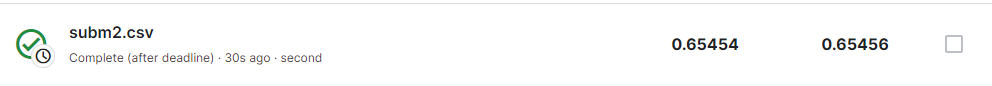